Вычисления на одном ядре по очереди:

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
from renju import run, run_test, Player
from agent import BackendAgent, HumanAgent, Agent, CnnAgent, BeamSearchAgent, ComplexCnnAgent, RandomBeamSearchAgent, RBSAcombined
from keras.models import load_model
import tensorflow as tf

import collections
import itertools
import logging
import time
import util
import subprocess
import abc

%matplotlib notebook

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
DEF_PY_PATH = '/media/oleg/Ubuntu2/oleg2/project/Renju'

class Config:
    def __init__(self, name):
        self.name = name
        
    def create_humanAgent(self):
        return HumanAgent(
            self.name,
        )
    
    def create_CnnAgent(self, color, name, model):
        return CnnAgent(
            color,
            name,
            model
        )
    
    def create_TreeAgent(self, color, black_model, white_model, main_model, name, num_to_check = 3):
        return BeamSearchAgent(
            agent = color,
            name = name,
            black_model = black_model,
            white_model = white_model, 
            num_to_check = num_to_check
        )
    
    def create_agent(self):
        return BackendAgent(
            self.cmd,
            self.name,
            env = {'PYTHONPATH': self.py_path},
            cwd = self.cwd
        )

In [4]:
black_model = load_model('optimal_black.h5')
black_model_graph = tf.get_default_graph()
black_model2 = load_model('rollout_black4096.h5')
black_model2_graph = tf.get_default_graph()
white_model = load_model('optimal_white.h5')
white_model_graph = tf.get_default_graph()
white_model2 = load_model('rollout_white4096.h5')
white_model2_graph = tf.get_default_graph()
#main_model = load_model('black4096.h5')

In [5]:
AL_PAN_model = load_model('model-2.h5')
AL_PAN_graph = tf.get_default_graph()

/usr/local/lib/python3.5/dist-packages/keras/engine/topology.py:1271: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


In [6]:
AL_PAN = CnnAgent(color = 'black', name = 'AL_PAN_black', model = (AL_PAN_model, AL_PAN_graph))

In [7]:
AL_PAN_white = CnnAgent(color = 'white', name = 'AL_PAN_white', model = (AL_PAN_model, AL_PAN_graph))

In [8]:
Oleg = Config(
    'Human'
).create_humanAgent()

In [9]:
Oleg2 = CnnAgent(color = 'black', name = 'black_top', model = (black_model, black_model_graph), verbose = 1)

In [10]:
Oleg25 = CnnAgent(color = 'black', name = 'black_ne_top', model = (black_model2, black_model2_graph), verbose = 1)

In [11]:
Oleg3 = CnnAgent(color = 'white', name = 'white_top', model = (white_model, white_model_graph), verbose = 1)

In [12]:
Oleg35 = CnnAgent(color = 'white', name = 'white_ne_top', model = (white_model2, white_model2_graph))

In [13]:
Oleg4 = ComplexCnnAgent(color = 'black', name = 'black', 
                        models = [(black_model, black_model_graph),
                                 (black_model2, black_model2_graph)])

In [14]:
Oleg5 = ComplexCnnAgent(color = 'white', name = 'white', 
                        models = [(white_model, white_model_graph),
                                 (white_model2, white_model2_graph)])

In [15]:
Tree = RandomBeamSearchAgent(color = 'black', name = 'TreeBlack', 
                   black_model = (black_model, black_model_graph), 
                   white_model = (white_model, white_model_graph), 
                   timeout = 2.9, high = 16, gamma = 1, fine = 1.0, bonus = 1.0, verbose = 0)

In [16]:
Tree_White = RandomBeamSearchAgent(color = 'white', name = 'TreeWhite', 
                   black_model = (black_model, black_model_graph), 
                   white_model = (white_model, white_model_graph), 
                   timeout = 2.9, high = 30, gamma = 1, fine = 1.0, bonus = 1.0, verbose = 0)

In [17]:
from mcts import MCTS

In [18]:
mcts_black = MCTS(color = 'black', name = 'MCTSBlack', 
                   black_model = (black_model, black_model_graph), 
                   white_model = (white_model, white_model_graph),
                   black_rollout = (black_model2, black_model2_graph), 
                   white_rollout = (white_model2, white_model2_graph),
                   timeout = 2.8, high = 10, gamma = 0.99, verbose = 0, min_prob = 0.8, param1 = 0.2, param2 = 0.65)

In [19]:
mcts_white = MCTS(color = 'white', name = 'MCTSWhite', 
                   black_model = (black_model, black_model_graph), 
                   white_model = (white_model, white_model_graph),
                   black_rollout = (black_model2, black_model2_graph), 
                   white_rollout = (white_model2, white_model2_graph), 
                   timeout = 2.8, high = 10, gamma = 0.99, verbose = 0, min_prob = 0.8, param1 = 0.2, param2 = 0.65)

In [20]:
mcts_black2 = MCTS(color = 'black', name = 'MCTSBlackOLD', 
                   black_model = (black_model, black_model_graph),
                   white_model = (white_model, white_model_graph),
                   black_rollout = (black_model, black_model_graph), 
                   white_rollout = (white_model, white_model_graph),
                   timeout = 9.7, high = 10, gamma = 1, verbose = 1, min_prob = 0.8)

<IPython.core.display.Javascript object>


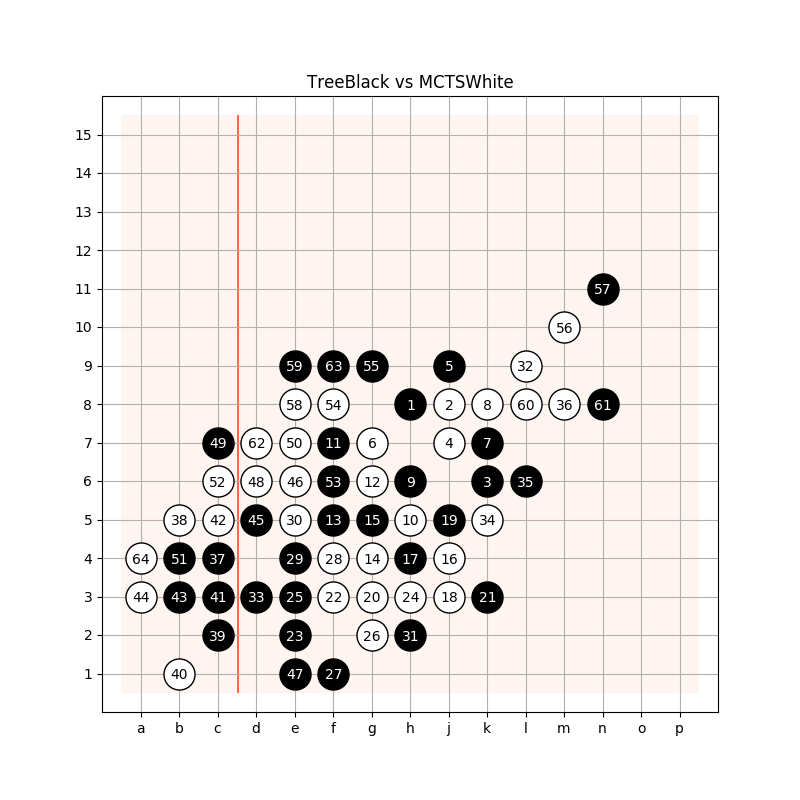

white

In [33]:
run_test(Tree, mcts_white)

In [36]:
result, moves = run(Tree, mcts_white, max_move_n=10, timeout=3.0)

In [37]:
result, moves

(none, 'h8 j8 k6 j7 j6 h6 k8 k9 h7 k5')

# Competition

In [27]:
agents = [Tree, Tree_White, mcts_black, mcts_white]

In [28]:
logging.FileHandler('log.txt')

In [43]:
import logging

In [44]:
def competition(agents, game_n=3, max_move_n=60, timeout=3.0, timeinit=2):
    table = {agent.name(): 0 for agent in agents}
    #logging.debug('Start comptetion...')
    
    for pair in itertools.combinations(agents, 2):
        for n in range(2 * game_n):
            black = pair[n % 2]
            white = pair[(n + 1) % 2]
            if (black._color != 'black' or white._color != 'white'):
                continue
                
            #logging.debug('Load backends...')
            time.sleep(timeinit)
            
            #logging.debug('Start game...')
            print('Game:')
            result, moves = run(black, white, max_move_n=max_move_n, timeout=timeout)
            #logging.debug(
            #    '{black} vs {white}: {moves} {result}'.format(
            #        black = black.name(),
            #        white = white.name(),
            #        moves = moves,
            #        result = str(result)
            #   )
            #)
            print('{black} vs {white}: {moves} {result}'.format(
                    black = black.name(),
                    white = white.name(),
                    moves = moves,
                    result = str(result)
                ))
            
            if result == Player.BLACK:
                table[black.name()] += 3
                
            if result == Player.WHITE:
                table[white.name()] += 3
                
            if not result:
                table[black.name()] += 1
                table[white.name()] += 1
                
            #logging.debug('Current results {}'.format(table))
            print('Current results {}'.format(table))
                
    return table

In [45]:
table = competition(agents, game_n=3)

Game:


ERROR:root:Error!
Traceback (most recent call last):
  File "/media/oleg/Ubuntu2/oleg2/project/Renju/renju.py", line 213, in run
    for game, _ in loop(game, black, white, timeout):
  File "/media/oleg/Ubuntu2/oleg2/project/Renju/renju.py", line 186, in loop
    probs = future.result(timeout=timeout)
  File "/usr/lib/python3.5/concurrent/futures/_base.py", line 407, in result
    raise TimeoutError()
concurrent.futures._base.TimeoutError
Stack (most recent call last):
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start
  

TreeBlack vs TreeWhite: h8 h9 k10 j9 g9 j7 j10 h10 k8 l8 j6 k7 l6 h7 g7 g6 m7 k5 f8 j8 f5 m9 k9 e9 n10 e8 f7 f6 e7 d6 e6 d7 d5 c4 g10 g11 f10 f11 e11 d12 f12 k11 n8 o9 n9 n7 m10 black
Current results {'TreeBlack': 3, 'MCTSBlack': 0, 'TreeWhite': 0, 'MCTSWhite': 0}
Game:


ERROR:root:Error!
Traceback (most recent call last):
  File "/media/oleg/Ubuntu2/oleg2/project/Renju/renju.py", line 186, in loop
    probs = future.result(timeout=timeout)
  File "/usr/lib/python3.5/concurrent/futures/_base.py", line 400, in result
    self._condition.wait(timeout)
  File "/usr/lib/python3.5/threading.py", line 297, in wait
    gotit = waiter.acquire(True, timeout)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/media/oleg/Ubuntu2/oleg2/project/Renju/renju.py", line 213, in run
    for game, _ in loop(game, black, white, timeout):
  File "/media/oleg/Ubuntu2/oleg2/project/Renju/renju.py", line 191, in loop
    yield game, probs
  File "/usr/lib/python3.5/concurrent/futures/_base.py", line 581, in __exit__
    self.shutdown(wait=True)
  File "/usr/lib/python3.5/concurrent/futures/thread.py", line 139, in shutdown
    t.join()
  File "/usr/lib/python3.5/threading.py", line 1054, in join


TreeBlack vs TreeWhite: h8 g8 f10 g9 g7 j9 white
Current results {'TreeBlack': 3, 'MCTSBlack': 0, 'TreeWhite': 3, 'MCTSWhite': 0}
Game:


ERROR:root:Error!
Traceback (most recent call last):
  File "/media/oleg/Ubuntu2/oleg2/project/Renju/renju.py", line 186, in loop
    probs = future.result(timeout=timeout)
  File "/usr/lib/python3.5/concurrent/futures/_base.py", line 400, in result
    self._condition.wait(timeout)
  File "/usr/lib/python3.5/threading.py", line 297, in wait
    gotit = waiter.acquire(True, timeout)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/media/oleg/Ubuntu2/oleg2/project/Renju/renju.py", line 213, in run
    for game, _ in loop(game, black, white, timeout):
  File "/media/oleg/Ubuntu2/oleg2/project/Renju/renju.py", line 191, in loop
    yield game, probs
  File "/usr/lib/python3.5/concurrent/futures/_base.py", line 581, in __exit__
    self.shutdown(wait=True)
  File "/usr/lib/python3.5/concurrent/futures/thread.py", line 139, in shutdown
    t.join()
  File "/usr/lib/python3.5/threading.py", line 1054, in join


TreeBlack vs TreeWhite: h8 j8 k6 j7 j9 g7 k7 k9 j5 k5 h7 h6 g5 h4 h10 h11 l8 black
Current results {'TreeBlack': 6, 'MCTSBlack': 0, 'TreeWhite': 3, 'MCTSWhite': 0}


KeyboardInterrupt: 

In [ ]:
print(table)